# CS4487 Project: Image classification

## Regarding course project
* External training data is not allowed. Learning can only be performed on the 50,000 training images in **CIFAR10**
* The [**CIFAR10** dataset](https://www.cs.toronto.edu/~kriz/cifar.html) was comprised of 60,000 32 × 32 color photographs of objects from 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.
* Submit the results at [Kaggle CS4487 Course Project](https://www.kaggle.com/c/cs4487cp/)
* The second test set containing roughly 2,000 images (refer to test_data/y_test.npy)

## Evaluation Criteria 

* ### Classification Accuaracy:
  ### $$ Acc(f, D) = \frac{1}{m}\sum_{i=1}^{m}\mathbb{I}[y^i = f(x^i)]$$

* ### File Format:
Upload a file in CSV format, such as:

|         **Index**         |         **Category**        |
|---------------------------|-----------------------------|
| 0                         | 8                           |
| 1                         | 4                           |
| 2                         | 6                           |
| 3                         | 1                           |
| ......                    | ......                      |
| 11999                     | 2                           |

PyTorch Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

---
## Table of content (for quick jump)
* ### [Import Library](#Import-Library)
* ### [Data Preparation](#Data-Preparation)
* ### [Common Functions](#Common-Functions)
  * #### [Training Function](#Training-function)
  * #### [Testing Function](#Testing-function)
  * #### [Test for each category](#Test-for-each-category)
  * #### [Save Model](#Save-Model)
  * #### [Print Time](#Print-Time)
  * #### [Progress Bar](#Progress-Bar)
* ### [Dual Path Networks](#Dual-Path-Networks)
  * #### [Training](#Train-DPN)
  * #### [Testing](#Test-DPN)
* ### [Run the model in project test data](#Run-the-model-in-project-test-data)
---
---

## Import Library

In [1]:
%pip install progressbar2

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
from numpy import *
import cv2
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib
import time
from _datetime import datetime
import pytz

import torch
import torchvision
from torch.utils import data
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import torch.optim as optim

from progressbar import *
from sys import platform

import matplotlib.pyplot as plt

In [ ]:
if platform == "win32":
    gd_root = "."  # For loacal run
    
else:  # run on Colab
    from google.colab import drive
    drive.mount('/content/gdrive')
    gd_root = "gdrive/My Drive/Colab Notebooks/CS4487/Project"

gd_root

In [3]:
gd_root = "."  # For loacal run

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

basic_path = "basic_cifar_net.pth"
PATH_DPN = "DPN_cifar.pth"

cuda


---
---
## Data Preparation

### Read CIFAR10 data
* The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle.
* Loaded in this way, each of the batch files contains a dictionary with the following elements:
  * **data**: 
    * a 10,000 x 3,072 numpy array of uint8s. Each row of the array stores a 32 x 32 colour image. 
    * The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. 
    * The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
  * **labels**: 
    * a list of 10,000 numbers in the range 0 - 9. 
    * The number at index i indicates the label of the ith image in the array data.
* The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:
  * **label_names** -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. 
  * For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

### Loading and normalizing CIFAR10 to dataloader

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [6]:
trainset = torchvision.datasets.CIFAR10(root=f'{gd_root}/data', train=True, download=False, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=64, 
                                           shuffle=True, 
                                           num_workers=8, 
                                           pin_memory=True
                                          )

testset = torchvision.datasets.CIFAR10(root=f'{gd_root}/data', train=False, download=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, 
                                          batch_size=32,
                                          shuffle=False, 
                                          num_workers=8,
                                          pin_memory=True
                                         )

In [7]:
train_size = len(trainset)
train_size
test_size = len(testset)
test_size
train_batch_len = len(train_loader)
train_batch_len
test_batch_len = len(test_loader)
test_batch_len

50000

10000

782

313

In [8]:
category_dict = {
    'airplane': 1, 
    'automobile': 2, 
    'bird': 3, 
    'cat': 4, 
    'deer': 5, 
    'dog': 6, 
    'frog': 7, 
    'horse': 8, 
    'ship': 9, 
    'truck': 10
}

---
---
## Common Functions

### Mixup 
From [Facebook AI Research](https://github.com/facebookresearch/mixup-cifar10/blob/master/README.md)

In [9]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if device == 'cuda':
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

### Training function

In [39]:
train_correct_rate = []
train_loss = []

In [40]:
def training(epoch_num: int, model_name: str, net):    
    
    final_loss = 0.0
    
    correct = 0
    total = 0
    
    for epoch in range(epoch_num):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        train_bar = progress_bar(train_batch_len)
        
        print_time_and_msg(f"Training for epoch {epoch + 1}")
        
        for batch_idx, (inputs, targets) in enumerate(train_loader, 0):
                        
            if device == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()
            
            # Mixup
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, 1.0)
            
            outputs = net(inputs)
            
            # forward + backward + optimize
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # print statistics
            running_loss += loss.item()
            final_loss = round(running_loss / train_batch_len, 3)
            
            train_bar.update(batch_idx)
        
        correct_rate = correct / total
        if epoch == 0:
            save_model(model_name, net)
        elif correct_rate > train_correct_rate[-1]:
            save_model(model_name, net)
        else:
            pass
        
        print_time_and_msg(f"Trained Epoch {epoch + 1}. loss: {final_loss}. Correct rate: {correct_rate}")
        train_correct_rate.append(correct_rate)
        train_loss.append(final_loss)
        print()
    
    print_time_and_msg(f'Finished training total {train_size} data for {epoch_num} epoches,\nthe final loss is {final_loss}')


### Testing function

In [12]:
def testing(net):
    test_bar = progress_bar(test_batch_len)
    correct = 0
    total = 0
    
    with torch.no_grad():
        for ti, (inputs, targets) in enumerate(test_loader):
            
            if device == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()
                
            loss = criterion(outputs, targets)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            test_bar.update(ti)
    print()
    print(f'Accuracy of the network on the {len(test_loader)} test images: {100 * correct / total}%')



### Test for each category

In [13]:
def test_for_each(net):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for (inputs, targets) in test_loader:
            
            if device == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()
                
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == targets).squeeze()
            for i in range(4):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    print()
    for i in range(10):
        print(f'Accuracy of {list(category_dict)[i]} : {round(100 * class_correct[i] / class_total[i], 2)}%')

### Save Model

In [41]:
def save_model(model_name: str, net):
    PATH_basic = f'{gd_root}/models/{model_name}'
    torch.save(net.state_dict(), PATH_basic)
    print_time_and_msg(f"Saved model")

### Print Time

In [15]:
def print_time_and_msg(msg: str) -> str:
    now_time = time.time()
    readable_time = datetime.fromtimestamp(now_time, pytz.timezone('Asia/Shanghai')).strftime(f'[%H:%M:%S] - {msg}')
    print(readable_time)

### Progress Bar

In [16]:
def progress_bar(max_val: int):
    bar = ProgressBar(
        widgets=[
            'Progress: ',
            Percentage(), ' ', 
            Bar('#'), ' ', 
            Timer(), ' ', 
            ETA(), ' '
        ], 
        max_value=max_val
    )
    return bar


### Plot

In [54]:
def plot_train_info(data: list, label: str):
    plt.figure(figsize=(20,10))
    x = [i for i in range(len(data))]
    y = data
    plt.plot(x, y, label=label)
    plt.xlabel("Epoch")
    plt.xticks(np.arange(min(x), max(x)+1, 1))

### Unpickle CIFAR data

In [52]:
def unpickle_cifar10(file: str) -> dict:
    full_name = f"{gd_root}/data/cifar-10-batches-py/{file}"
    
    with open(full_name, 'rb') as fi:
        cifar10_dict = pickle.load(fi, encoding='bytes')
    return cifar10_dict

cifar_meta = unpickle_cifar10("batches.meta")
cifar_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

## Dual Path Networks

### Define DPN

In [19]:
class Bottleneck(nn.Module):
    def __init__(self, last_planes, in_planes, out_planes, dense_depth, stride, first_layer):
        super(Bottleneck, self).__init__()
        self.out_planes = out_planes
        self.dense_depth = dense_depth

        self.conv1 = nn.Conv2d(last_planes, in_planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=32, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        self.conv3 = nn.Conv2d(in_planes, out_planes + dense_depth, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes+dense_depth)

        self.shortcut = nn.Sequential()
        if first_layer:
            self.shortcut = nn.Sequential(
                nn.Conv2d(last_planes, out_planes + dense_depth, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes + dense_depth)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        x = self.shortcut(x)
        d = self.out_planes
        out = torch.cat([x[:,:d,:,:] + out[:,:d,:,:], x[:,d:,:,:], out[:,d:,:,:]], 1)
        out = F.relu(out)
        return out


In [20]:
class DPN(nn.Module):
    def __init__(self, cfg):
        super(DPN, self).__init__()
        in_planes, out_planes = cfg['in_planes'], cfg['out_planes']
        num_blocks, dense_depth = cfg['num_blocks'], cfg['dense_depth']

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.last_planes = 64
        self.layer1 = self._make_layer(in_planes[0], out_planes[0], num_blocks[0], dense_depth[0], stride=1)
        self.layer2 = self._make_layer(in_planes[1], out_planes[1], num_blocks[1], dense_depth[1], stride=2)
        self.layer3 = self._make_layer(in_planes[2], out_planes[2], num_blocks[2], dense_depth[2], stride=2)
        self.layer4 = self._make_layer(in_planes[3], out_planes[3], num_blocks[3], dense_depth[3], stride=2)
        self.linear = nn.Linear(out_planes[3] + (num_blocks[3] + 1) * dense_depth[3], 10)

    def _make_layer(self, in_planes, out_planes, num_blocks, dense_depth, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for i,stride in enumerate(strides):
            layers.append(Bottleneck(self.last_planes, in_planes, out_planes, dense_depth, stride, i==0))
            self.last_planes = out_planes + (i + 2) * dense_depth
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [21]:
def DPN26():
    cfg = {
        'in_planes': (96,192,384,768),
        'out_planes': (256,512,1024,2048),
        'num_blocks': (2,2,2,2),
        'dense_depth': (16,32,24,128)
    }
    return DPN(cfg)

def DPN92():
    cfg = {
        'in_planes': (96,192,384,768),
        'out_planes': (256,512,1024,2048),
        'num_blocks': (3,4,20,3),
        'dense_depth': (16,32,24,128)
    }
    return DPN(cfg)

### Train DPN

In [ ]:
DPN_net = DPN92()
DPN_net.to(device)
if device == 'cuda':
    DPN_net = torch.nn.DataParallel(DPN_net)
    cudnn.benchmark = True

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(DPN_net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

#### Go to [training function](#Training-function)

In [42]:
model_PATH = f"{gd_root}/models/{PATH_DPN}"
DPN_net.load_state_dict(torch.load(model_PATH))
print_time_and_msg(f"Loaded model: {PATH_DPN}")

<All keys matched successfully>

[23:55:58] - Loaded model: DPN_cifar.pth


In [35]:
epoches = 500

In [43]:
print_time_and_msg(f"Start training for {epoches} epoches\n")
training(epoch_num=epoches, model_name=PATH_DPN, net=DPN_net)

[23:56:00] - Start training for 500 epoches

[23:56:00] - Training for epoch 1


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[23:58:45] - Saved model
[23:58:45] - Trained Epoch 1. loss: 1.392. Correct rate: 0.41788

[23:58:45] - Training for epoch 2


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:01:31] - Trained Epoch 2. loss: 1.423. Correct rate: 0.41326

[00:01:31] - Training for epoch 3


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:04:16] - Saved model
[00:04:16] - Trained Epoch 3. loss: 1.407. Correct rate: 0.41518

[00:04:16] - Training for epoch 4


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:07:02] - Trained Epoch 4. loss: 1.409. Correct rate: 0.40987

[00:07:02] - Training for epoch 5


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:09:47] - Saved model
[00:09:47] - Trained Epoch 5. loss: 1.428. Correct rate: 0.4107

[00:09:47] - Training for epoch 6


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:12:33] - Trained Epoch 6. loss: 1.396. Correct rate: 0.40864

[00:12:33] - Training for epoch 7


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:15:18] - Saved model
[00:15:18] - Trained Epoch 7. loss: 1.393. Correct rate: 0.4106714285714286

[00:15:18] - Training for epoch 8


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:18:03] - Trained Epoch 8. loss: 1.404. Correct rate: 0.4097375

[00:18:03] - Training for epoch 9


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:20:49] - Saved model
[00:20:49] - Trained Epoch 9. loss: 1.413. Correct rate: 0.4102044444444444

[00:20:49] - Training for epoch 10


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:23:34] - Saved model
[00:23:34] - Trained Epoch 10. loss: 1.4. Correct rate: 0.4115

[00:23:34] - Training for epoch 11


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:26:20] - Saved model
[00:26:20] - Trained Epoch 11. loss: 1.392. Correct rate: 0.4117618181818182

[00:26:20] - Training for epoch 12


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:29:05] - Saved model
[00:29:05] - Trained Epoch 12. loss: 1.402. Correct rate: 0.4129966666666667

[00:29:05] - Training for epoch 13


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:31:50] - Trained Epoch 13. loss: 1.401. Correct rate: 0.4121215384615385

[00:31:50] - Training for epoch 14


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:34:36] - Saved model
[00:34:36] - Trained Epoch 14. loss: 1.403. Correct rate: 0.41276285714285715

[00:34:36] - Training for epoch 15


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:37:21] - Saved model
[00:37:21] - Trained Epoch 15. loss: 1.413. Correct rate: 0.413596

[00:37:21] - Training for epoch 16


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:40:07] - Trained Epoch 16. loss: 1.39. Correct rate: 0.41349375

[00:40:07] - Training for epoch 17


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:42:52] - Saved model
[00:42:52] - Trained Epoch 17. loss: 1.402. Correct rate: 0.41411882352941176

[00:42:52] - Training for epoch 18


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:45:37] - Saved model
[00:45:37] - Trained Epoch 18. loss: 1.404. Correct rate: 0.4142122222222222

[00:45:37] - Training for epoch 19


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:48:23] - Trained Epoch 19. loss: 1.381. Correct rate: 0.4141347368421053

[00:48:23] - Training for epoch 20


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:51:08] - Trained Epoch 20. loss: 1.413. Correct rate: 0.413812

[00:51:08] - Training for epoch 21


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:53:53] - Saved model
[00:53:53] - Trained Epoch 21. loss: 1.393. Correct rate: 0.41409523809523807

[00:53:53] - Training for epoch 22


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:56:38] - Trained Epoch 22. loss: 1.401. Correct rate: 0.4140063636363636

[00:56:38] - Training for epoch 23


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[00:59:24] - Saved model
[00:59:24] - Trained Epoch 23. loss: 1.388. Correct rate: 0.4145869565217391

[00:59:24] - Training for epoch 24


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:02:09] - Trained Epoch 24. loss: 1.384. Correct rate: 0.41371833333333335

[01:02:09] - Training for epoch 25


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:04:55] - Saved model
[01:04:55] - Trained Epoch 25. loss: 1.389. Correct rate: 0.4138528

[01:04:55] - Training for epoch 26


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:07:40] - Trained Epoch 26. loss: 1.395. Correct rate: 0.41367076923076923

[01:07:40] - Training for epoch 27


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:10:26] - Saved model
[01:10:26] - Trained Epoch 27. loss: 1.4. Correct rate: 0.41405333333333333

[01:10:26] - Training for epoch 28


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:13:11] - Saved model
[01:13:11] - Trained Epoch 28. loss: 1.385. Correct rate: 0.41416642857142855

[01:13:11] - Training for epoch 29


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:15:57] - Saved model
[01:15:57] - Trained Epoch 29. loss: 1.391. Correct rate: 0.4145110344827586

[01:15:57] - Training for epoch 30


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:18:42] - Trained Epoch 30. loss: 1.377. Correct rate: 0.414048

[01:18:42] - Training for epoch 31


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:21:28] - Saved model
[01:21:28] - Trained Epoch 31. loss: 1.387. Correct rate: 0.41411935483870965

[01:21:28] - Training for epoch 32


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:24:13] - Saved model
[01:24:13] - Trained Epoch 32. loss: 1.381. Correct rate: 0.4143725

[01:24:13] - Training for epoch 33


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:26:59] - Saved model
[01:26:59] - Trained Epoch 33. loss: 1.389. Correct rate: 0.41438969696969696

[01:26:59] - Training for epoch 34


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:29:44] - Trained Epoch 34. loss: 1.379. Correct rate: 0.4139741176470588

[01:29:44] - Training for epoch 35


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:32:29] - Saved model
[01:32:29] - Trained Epoch 35. loss: 1.376. Correct rate: 0.4139857142857143

[01:32:29] - Training for epoch 36


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:35:15] - Saved model
[01:35:15] - Trained Epoch 36. loss: 1.411. Correct rate: 0.4141972222222222

[01:35:15] - Training for epoch 37


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:38:00] - Trained Epoch 37. loss: 1.376. Correct rate: 0.4141335135135135

[01:38:00] - Training for epoch 38


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:40:46] - Saved model
[01:40:46] - Trained Epoch 38. loss: 1.375. Correct rate: 0.41436736842105265

[01:40:46] - Training for epoch 39


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:43:31] - Saved model
[01:43:31] - Trained Epoch 39. loss: 1.373. Correct rate: 0.41458923076923077

[01:43:31] - Training for epoch 40


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:46:17] - Trained Epoch 40. loss: 1.397. Correct rate: 0.414456

[01:46:17] - Training for epoch 41


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:49:02] - Saved model
[01:49:02] - Trained Epoch 41. loss: 1.367. Correct rate: 0.4148326829268293

[01:49:02] - Training for epoch 42


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:51:47] - Trained Epoch 42. loss: 1.393. Correct rate: 0.4145061904761905

[01:51:47] - Training for epoch 43


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:54:33] - Saved model
[01:54:33] - Trained Epoch 43. loss: 1.381. Correct rate: 0.41452744186046514

[01:54:33] - Training for epoch 44


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[01:57:18] - Trained Epoch 44. loss: 1.385. Correct rate: 0.41439954545454544

[01:57:18] - Training for epoch 45


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:00:03] - Trained Epoch 45. loss: 1.364. Correct rate: 0.41424444444444447

[02:00:03] - Training for epoch 46


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:02:49] - Trained Epoch 46. loss: 1.394. Correct rate: 0.4138504347826087

[02:02:49] - Training for epoch 47


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:05:34] - Trained Epoch 47. loss: 1.39. Correct rate: 0.41374255319148934

[02:05:34] - Training for epoch 48


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:08:19] - Trained Epoch 48. loss: 1.373. Correct rate: 0.41356791666666665

[02:08:19] - Training for epoch 49


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:11:05] - Saved model
[02:11:05] - Trained Epoch 49. loss: 1.376. Correct rate: 0.413794693877551

[02:11:05] - Training for epoch 50


Progress:  99% |####################### | Elapsed Time: 0:02:47 ETA:   0:00:00 

[02:13:53] - Trained Epoch 50. loss: 1.392. Correct rate: 0.4136916

[02:13:53] - Training for epoch 51


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:16:39] - Saved model
[02:16:39] - Trained Epoch 51. loss: 1.387. Correct rate: 0.41376823529411766

[02:16:39] - Training for epoch 52


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:19:24] - Saved model
[02:19:24] - Trained Epoch 52. loss: 1.403. Correct rate: 0.41384692307692306

[02:19:24] - Training for epoch 53


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:22:09] - Trained Epoch 53. loss: 1.373. Correct rate: 0.4138441509433962

[02:22:09] - Training for epoch 54


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:24:55] - Saved model
[02:24:55] - Trained Epoch 54. loss: 1.358. Correct rate: 0.4143085185185185

[02:24:55] - Training for epoch 55


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:27:40] - Trained Epoch 55. loss: 1.357. Correct rate: 0.4141687272727273

[02:27:40] - Training for epoch 56


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:30:26] - Saved model
[02:30:26] - Trained Epoch 56. loss: 1.384. Correct rate: 0.41427821428571426

[02:30:26] - Training for epoch 57


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:33:11] - Saved model
[02:33:11] - Trained Epoch 57. loss: 1.366. Correct rate: 0.41430666666666666

[02:33:11] - Training for epoch 58


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:35:56] - Saved model
[02:35:56] - Trained Epoch 58. loss: 1.379. Correct rate: 0.41441

[02:35:56] - Training for epoch 59


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:38:42] - Saved model
[02:38:42] - Trained Epoch 59. loss: 1.367. Correct rate: 0.41470135593220336

[02:38:42] - Training for epoch 60


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:41:27] - Saved model
[02:41:27] - Trained Epoch 60. loss: 1.364. Correct rate: 0.41482366666666665

[02:41:27] - Training for epoch 61


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:44:13] - Saved model
[02:44:13] - Trained Epoch 61. loss: 1.363. Correct rate: 0.4149232786885246

[02:44:13] - Training for epoch 62


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:46:59] - Saved model
[02:46:59] - Trained Epoch 62. loss: 1.373. Correct rate: 0.41496967741935487

[02:46:59] - Training for epoch 63


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:49:44] - Trained Epoch 63. loss: 1.39. Correct rate: 0.41496222222222223

[02:49:44] - Training for epoch 64


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:52:29] - Saved model
[02:52:29] - Trained Epoch 64. loss: 1.381. Correct rate: 0.4150334375

[02:52:29] - Training for epoch 65


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:55:15] - Saved model
[02:55:15] - Trained Epoch 65. loss: 1.37. Correct rate: 0.41530153846153844

[02:55:15] - Training for epoch 66


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[02:58:00] - Trained Epoch 66. loss: 1.372. Correct rate: 0.41510878787878785

[02:58:00] - Training for epoch 67


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:00:46] - Trained Epoch 67. loss: 1.374. Correct rate: 0.4150662686567164

[03:00:46] - Training for epoch 68


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:03:31] - Trained Epoch 68. loss: 1.373. Correct rate: 0.41497382352941176

[03:03:31] - Training for epoch 69


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:06:17] - Saved model
[03:06:17] - Trained Epoch 69. loss: 1.342. Correct rate: 0.4152704347826087

[03:06:17] - Training for epoch 70


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:09:02] - Saved model
[03:09:02] - Trained Epoch 70. loss: 1.364. Correct rate: 0.41556771428571426

[03:09:02] - Training for epoch 71


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:11:48] - Saved model
[03:11:48] - Trained Epoch 71. loss: 1.378. Correct rate: 0.41587971830985915

[03:11:48] - Training for epoch 72


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:14:33] - Saved model
[03:14:33] - Trained Epoch 72. loss: 1.358. Correct rate: 0.41595333333333334

[03:14:33] - Training for epoch 73


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:17:19] - Saved model
[03:17:19] - Trained Epoch 73. loss: 1.358. Correct rate: 0.41597041095890414

[03:17:19] - Training for epoch 74


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:20:04] - Trained Epoch 74. loss: 1.367. Correct rate: 0.41587756756756755

[03:20:04] - Training for epoch 75


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:22:49] - Trained Epoch 75. loss: 1.365. Correct rate: 0.41586266666666666

[03:22:49] - Training for epoch 76


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:25:35] - Trained Epoch 76. loss: 1.37. Correct rate: 0.41579947368421055

[03:25:35] - Training for epoch 77


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:28:20] - Saved model
[03:28:20] - Trained Epoch 77. loss: 1.369. Correct rate: 0.41594155844155845

[03:28:20] - Training for epoch 78


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:31:06] - Saved model
[03:31:06] - Trained Epoch 78. loss: 1.356. Correct rate: 0.41600205128205126

[03:31:06] - Training for epoch 79


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:33:51] - Trained Epoch 79. loss: 1.363. Correct rate: 0.41588303797468357

[03:33:51] - Training for epoch 80


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:36:37] - Saved model
[03:36:37] - Trained Epoch 80. loss: 1.358. Correct rate: 0.4159155

[03:36:37] - Training for epoch 81


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:39:22] - Saved model
[03:39:22] - Trained Epoch 81. loss: 1.357. Correct rate: 0.4159530864197531

[03:39:22] - Training for epoch 82


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:42:08] - Saved model
[03:42:08] - Trained Epoch 82. loss: 1.372. Correct rate: 0.4159790243902439

[03:42:08] - Training for epoch 83


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:44:53] - Trained Epoch 83. loss: 1.359. Correct rate: 0.4159226506024096

[03:44:53] - Training for epoch 84


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:47:39] - Saved model
[03:47:39] - Trained Epoch 84. loss: 1.357. Correct rate: 0.41600261904761904

[03:47:39] - Training for epoch 85


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:50:24] - Saved model
[03:50:24] - Trained Epoch 85. loss: 1.364. Correct rate: 0.4160889411764706

[03:50:24] - Training for epoch 86


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:53:09] - Saved model
[03:53:09] - Trained Epoch 86. loss: 1.339. Correct rate: 0.41610023255813955

[03:53:09] - Training for epoch 87


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:55:55] - Saved model
[03:55:55] - Trained Epoch 87. loss: 1.369. Correct rate: 0.41626551724137933

[03:55:55] - Training for epoch 88


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[03:58:40] - Trained Epoch 88. loss: 1.382. Correct rate: 0.4162620454545455

[03:58:40] - Training for epoch 89


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:01:25] - Trained Epoch 89. loss: 1.369. Correct rate: 0.4160611235955056

[04:01:25] - Training for epoch 90


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:04:11] - Saved model
[04:04:11] - Trained Epoch 90. loss: 1.382. Correct rate: 0.41610888888888886

[04:04:11] - Training for epoch 91


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:06:57] - Saved model
[04:06:57] - Trained Epoch 91. loss: 1.355. Correct rate: 0.41617626373626376

[04:06:57] - Training for epoch 92


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:09:42] - Trained Epoch 92. loss: 1.361. Correct rate: 0.4161215217391304

[04:09:42] - Training for epoch 93


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:12:27] - Saved model
[04:12:27] - Trained Epoch 93. loss: 1.349. Correct rate: 0.41612666666666664

[04:12:27] - Training for epoch 94


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:15:13] - Trained Epoch 94. loss: 1.37. Correct rate: 0.416081914893617

[04:15:13] - Training for epoch 95


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:17:58] - Trained Epoch 95. loss: 1.366. Correct rate: 0.416068

[04:17:58] - Training for epoch 96


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:20:43] - Trained Epoch 96. loss: 1.369. Correct rate: 0.41603958333333335

[04:20:43] - Training for epoch 97


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:23:29] - Trained Epoch 97. loss: 1.364. Correct rate: 0.41587154639175256

[04:23:29] - Training for epoch 98


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:26:14] - Trained Epoch 98. loss: 1.374. Correct rate: 0.41568204081632654

[04:26:14] - Training for epoch 99


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:28:59] - Trained Epoch 99. loss: 1.382. Correct rate: 0.41558949494949493

[04:28:59] - Training for epoch 100


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:31:45] - Saved model
[04:31:45] - Trained Epoch 100. loss: 1.377. Correct rate: 0.4157048

[04:31:45] - Training for epoch 101


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:34:30] - Trained Epoch 101. loss: 1.379. Correct rate: 0.41566475247524753

[04:34:30] - Training for epoch 102


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:37:15] - Trained Epoch 102. loss: 1.343. Correct rate: 0.4156107843137255

[04:37:15] - Training for epoch 103


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:40:01] - Trained Epoch 103. loss: 1.369. Correct rate: 0.4155712621359223

[04:40:01] - Training for epoch 104


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:42:46] - Saved model
[04:42:46] - Trained Epoch 104. loss: 1.33. Correct rate: 0.4156098076923077

[04:42:46] - Training for epoch 105


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:45:32] - Trained Epoch 105. loss: 1.337. Correct rate: 0.41560933333333333

[04:45:32] - Training for epoch 106


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:48:17] - Saved model
[04:48:17] - Trained Epoch 106. loss: 1.372. Correct rate: 0.41579396226415094

[04:48:17] - Training for epoch 107


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:51:02] - Trained Epoch 107. loss: 1.352. Correct rate: 0.4157581308411215

[04:51:02] - Training for epoch 108


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:53:48] - Saved model
[04:53:48] - Trained Epoch 108. loss: 1.353. Correct rate: 0.41594425925925926

[04:53:48] - Training for epoch 109


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:56:33] - Saved model
[04:56:33] - Trained Epoch 109. loss: 1.35. Correct rate: 0.41601174311926603

[04:56:33] - Training for epoch 110


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[04:59:19] - Saved model
[04:59:19] - Trained Epoch 110. loss: 1.367. Correct rate: 0.41616854545454546

[04:59:19] - Training for epoch 111


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:02:04] - Trained Epoch 111. loss: 1.367. Correct rate: 0.4161282882882883

[05:02:04] - Training for epoch 112


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:04:50] - Saved model
[05:04:50] - Trained Epoch 112. loss: 1.353. Correct rate: 0.4162567857142857

[05:04:50] - Training for epoch 113


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:07:35] - Saved model
[05:07:35] - Trained Epoch 113. loss: 1.368. Correct rate: 0.41639309734513275

[05:07:35] - Training for epoch 114


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:10:21] - Saved model
[05:10:21] - Trained Epoch 114. loss: 1.355. Correct rate: 0.4164757894736842

[05:10:21] - Training for epoch 115


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:13:06] - Saved model
[05:13:06] - Trained Epoch 115. loss: 1.349. Correct rate: 0.4164970434782609

[05:13:06] - Training for epoch 116


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:15:52] - Saved model
[05:15:52] - Trained Epoch 116. loss: 1.353. Correct rate: 0.4165206896551724

[05:15:52] - Training for epoch 117


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:18:37] - Saved model
[05:18:37] - Trained Epoch 117. loss: 1.349. Correct rate: 0.4166374358974359

[05:18:37] - Training for epoch 118


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:21:23] - Saved model
[05:21:23] - Trained Epoch 118. loss: 1.348. Correct rate: 0.41673338983050845

[05:21:23] - Training for epoch 119


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:24:08] - Saved model
[05:24:08] - Trained Epoch 119. loss: 1.345. Correct rate: 0.4168411764705882

[05:24:08] - Training for epoch 120


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:26:54] - Saved model
[05:26:54] - Trained Epoch 120. loss: 1.348. Correct rate: 0.4169231666666667

[05:26:54] - Training for epoch 121


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:29:40] - Saved model
[05:29:40] - Trained Epoch 121. loss: 1.361. Correct rate: 0.41702512396694214

[05:29:40] - Training for epoch 122


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:32:25] - Trained Epoch 122. loss: 1.354. Correct rate: 0.4170018032786885

[05:32:25] - Training for epoch 123


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:35:10] - Trained Epoch 123. loss: 1.348. Correct rate: 0.41696390243902437

[05:35:10] - Training for epoch 124


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:37:56] - Saved model
[05:37:56] - Trained Epoch 124. loss: 1.342. Correct rate: 0.4170017741935484

[05:37:56] - Training for epoch 125


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:40:41] - Saved model
[05:40:41] - Trained Epoch 125. loss: 1.347. Correct rate: 0.41711792

[05:40:41] - Training for epoch 126


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:43:27] - Saved model
[05:43:27] - Trained Epoch 126. loss: 1.335. Correct rate: 0.4171249206349206

[05:43:27] - Training for epoch 127


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:46:13] - Saved model
[05:46:13] - Trained Epoch 127. loss: 1.334. Correct rate: 0.41728299212598424

[05:46:13] - Training for epoch 128


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:48:58] - Trained Epoch 128. loss: 1.348. Correct rate: 0.41721359375

[05:48:58] - Training for epoch 129


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:51:44] - Saved model
[05:51:44] - Trained Epoch 129. loss: 1.339. Correct rate: 0.41722217054263566

[05:51:44] - Training for epoch 130


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:54:29] - Trained Epoch 130. loss: 1.344. Correct rate: 0.41717876923076924

[05:54:29] - Training for epoch 131


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[05:57:15] - Saved model
[05:57:15] - Trained Epoch 131. loss: 1.354. Correct rate: 0.41723480916030536

[05:57:15] - Training for epoch 132


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:00:00] - Trained Epoch 132. loss: 1.363. Correct rate: 0.4171498484848485

[06:00:00] - Training for epoch 133


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:02:45] - Saved model
[06:02:45] - Trained Epoch 133. loss: 1.354. Correct rate: 0.4172470676691729

[06:02:45] - Training for epoch 134


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:05:31] - Saved model
[06:05:31] - Trained Epoch 134. loss: 1.341. Correct rate: 0.4173885074626866

[06:05:31] - Training for epoch 135


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:08:16] - Saved model
[06:08:16] - Trained Epoch 135. loss: 1.347. Correct rate: 0.4174797037037037

[06:08:16] - Training for epoch 136


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:11:02] - Saved model
[06:11:02] - Trained Epoch 136. loss: 1.33. Correct rate: 0.4174839705882353

[06:11:02] - Training for epoch 137


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:13:47] - Trained Epoch 137. loss: 1.355. Correct rate: 0.41742598540145986

[06:13:47] - Training for epoch 138


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:16:33] - Saved model
[06:16:33] - Trained Epoch 138. loss: 1.346. Correct rate: 0.41765608695652173

[06:16:33] - Training for epoch 139


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:19:18] - Saved model
[06:19:18] - Trained Epoch 139. loss: 1.338. Correct rate: 0.41772892086330937

[06:19:18] - Training for epoch 140


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:22:04] - Saved model
[06:22:04] - Trained Epoch 140. loss: 1.339. Correct rate: 0.4177485714285714

[06:22:04] - Training for epoch 141


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:24:49] - Saved model
[06:24:49] - Trained Epoch 141. loss: 1.334. Correct rate: 0.41790056737588654

[06:24:49] - Training for epoch 142


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:27:35] - Trained Epoch 142. loss: 1.355. Correct rate: 0.4178780281690141

[06:27:35] - Training for epoch 143


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:30:20] - Saved model
[06:30:20] - Trained Epoch 143. loss: 1.33. Correct rate: 0.4178806993006993

[06:30:20] - Training for epoch 144


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[06:33:06] - Trained Epoch 144. loss: 1.337. Correct rate: 0.41782847222222225

[06:33:06] - Training for epoch 145


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:35:51] - Trained Epoch 145. loss: 1.357. Correct rate: 0.41779158620689655

[06:35:51] - Training for epoch 146


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:38:37] - Trained Epoch 146. loss: 1.346. Correct rate: 0.41772246575342464

[06:38:37] - Training for epoch 147


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:41:22] - Trained Epoch 147. loss: 1.335. Correct rate: 0.41771537414965987

[06:41:22] - Training for epoch 148


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:44:08] - Trained Epoch 148. loss: 1.355. Correct rate: 0.41770445945945944

[06:44:08] - Training for epoch 149


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:46:53] - Trained Epoch 149. loss: 1.328. Correct rate: 0.4176826845637584

[06:46:53] - Training for epoch 150


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:49:39] - Trained Epoch 150. loss: 1.328. Correct rate: 0.4176686666666667

[06:49:39] - Training for epoch 151


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:52:24] - Saved model
[06:52:24] - Trained Epoch 151. loss: 1.34. Correct rate: 0.41772596026490066

[06:52:24] - Training for epoch 152


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[06:55:10] - Saved model
[06:55:10] - Trained Epoch 152. loss: 1.336. Correct rate: 0.41775644736842105

[06:55:10] - Training for epoch 153


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[06:57:55] - Trained Epoch 153. loss: 1.346. Correct rate: 0.41770117647058824

[06:57:55] - Training for epoch 154


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[07:00:41] - Saved model
[07:00:41] - Trained Epoch 154. loss: 1.345. Correct rate: 0.41771051948051946

[07:00:41] - Training for epoch 155


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[07:03:27] - Saved model
[07:03:27] - Trained Epoch 155. loss: 1.366. Correct rate: 0.4177153548387097

[07:03:27] - Training for epoch 156


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[07:06:12] - Saved model
[07:06:12] - Trained Epoch 156. loss: 1.345. Correct rate: 0.4177173076923077

[07:06:12] - Training for epoch 157


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[07:08:58] - Trained Epoch 157. loss: 1.34. Correct rate: 0.41767019108280257

[07:08:58] - Training for epoch 158


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[07:11:43] - Saved model
[07:11:43] - Trained Epoch 158. loss: 1.355. Correct rate: 0.4176891139240506

[07:11:43] - Training for epoch 159


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[07:14:29] - Trained Epoch 159. loss: 1.364. Correct rate: 0.4176352201257862

[07:14:29] - Training for epoch 160


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[07:17:14] - Saved model
[07:17:14] - Trained Epoch 160. loss: 1.345. Correct rate: 0.417669875

[07:17:14] - Training for epoch 161


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[07:20:00] - Saved model
[07:20:00] - Trained Epoch 161. loss: 1.334. Correct rate: 0.4177253416149068

[07:20:00] - Training for epoch 162


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[07:22:46] - Saved model
[07:22:46] - Trained Epoch 162. loss: 1.345. Correct rate: 0.4178628395061728

[07:22:46] - Training for epoch 163


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[07:25:32] - Saved model
[07:25:32] - Trained Epoch 163. loss: 1.353. Correct rate: 0.41795006134969326

[07:25:32] - Training for epoch 164


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[07:28:17] - Saved model
[07:28:17] - Trained Epoch 164. loss: 1.332. Correct rate: 0.41805243902439027

[07:28:17] - Training for epoch 165


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[07:31:03] - Trained Epoch 165. loss: 1.328. Correct rate: 0.4180012121212121

[07:31:03] - Training for epoch 166


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[07:33:49] - Trained Epoch 166. loss: 1.325. Correct rate: 0.41798168674698793

[07:33:49] - Training for epoch 167


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[07:36:34] - Trained Epoch 167. loss: 1.328. Correct rate: 0.4179528143712575

[07:36:34] - Training for epoch 168


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[07:39:21] - Saved model
[07:39:21] - Trained Epoch 168. loss: 1.331. Correct rate: 0.4180083333333333

[07:39:21] - Training for epoch 169


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[07:42:06] - Trained Epoch 169. loss: 1.353. Correct rate: 0.4179430769230769

[07:42:06] - Training for epoch 170


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[07:44:53] - Saved model
[07:44:53] - Trained Epoch 170. loss: 1.319. Correct rate: 0.4180394117647059

[07:44:53] - Training for epoch 171


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[07:47:38] - Trained Epoch 171. loss: 1.323. Correct rate: 0.4180008187134503

[07:47:38] - Training for epoch 172


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[07:50:24] - Saved model
[07:50:24] - Trained Epoch 172. loss: 1.33. Correct rate: 0.4181096511627907

[07:50:24] - Training for epoch 173


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[07:53:10] - Saved model
[07:53:10] - Trained Epoch 173. loss: 1.322. Correct rate: 0.41819537572254334

[07:53:10] - Training for epoch 174


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[07:55:56] - Saved model
[07:55:56] - Trained Epoch 174. loss: 1.353. Correct rate: 0.4182937931034483

[07:55:56] - Training for epoch 175


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[07:58:42] - Saved model
[07:58:42] - Trained Epoch 175. loss: 1.342. Correct rate: 0.41845234285714283

[07:58:42] - Training for epoch 176


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:01:28] - Saved model
[08:01:28] - Trained Epoch 176. loss: 1.337. Correct rate: 0.41857568181818183

[08:01:28] - Training for epoch 177


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:04:14] - Saved model
[08:04:14] - Trained Epoch 177. loss: 1.325. Correct rate: 0.41865389830508476

[08:04:14] - Training for epoch 178


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:07:00] - Trained Epoch 178. loss: 1.342. Correct rate: 0.41859078651685394

[08:07:00] - Training for epoch 179


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:09:46] - Saved model
[08:09:46] - Trained Epoch 179. loss: 1.354. Correct rate: 0.41862156424581004

[08:09:46] - Training for epoch 180


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:12:32] - Saved model
[08:12:32] - Trained Epoch 180. loss: 1.351. Correct rate: 0.41866044444444445

[08:12:32] - Training for epoch 181


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:15:18] - Saved model
[08:15:18] - Trained Epoch 181. loss: 1.348. Correct rate: 0.41869955801104974

[08:15:18] - Training for epoch 182


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:18:04] - Saved model
[08:18:04] - Trained Epoch 182. loss: 1.357. Correct rate: 0.41875604395604393

[08:18:04] - Training for epoch 183


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:20:50] - Saved model
[08:20:50] - Trained Epoch 183. loss: 1.342. Correct rate: 0.4188234972677596

[08:20:50] - Training for epoch 184


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:23:36] - Saved model
[08:23:36] - Trained Epoch 184. loss: 1.337. Correct rate: 0.41884739130434784

[08:23:36] - Training for epoch 185


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:26:22] - Saved model
[08:26:22] - Trained Epoch 185. loss: 1.338. Correct rate: 0.4188727567567568

[08:26:22] - Training for epoch 186


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:29:08] - Trained Epoch 186. loss: 1.331. Correct rate: 0.41879698924731185

[08:29:08] - Training for epoch 187


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:31:54] - Trained Epoch 187. loss: 1.343. Correct rate: 0.4187855614973262

[08:31:54] - Training for epoch 188


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:34:40] - Saved model
[08:34:40] - Trained Epoch 188. loss: 1.338. Correct rate: 0.41892606382978725

[08:34:40] - Training for epoch 189


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:37:26] - Saved model
[08:37:26] - Trained Epoch 189. loss: 1.338. Correct rate: 0.4189797883597884

[08:37:26] - Training for epoch 190


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:40:12] - Saved model
[08:40:12] - Trained Epoch 190. loss: 1.313. Correct rate: 0.4191398947368421

[08:40:12] - Training for epoch 191


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:42:58] - Saved model
[08:42:58] - Trained Epoch 191. loss: 1.344. Correct rate: 0.41915465968586385

[08:42:58] - Training for epoch 192


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:45:44] - Saved model
[08:45:44] - Trained Epoch 192. loss: 1.347. Correct rate: 0.419169375

[08:45:44] - Training for epoch 193


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:48:30] - Saved model
[08:48:30] - Trained Epoch 193. loss: 1.333. Correct rate: 0.4193178238341969

[08:48:30] - Training for epoch 194


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:51:16] - Saved model
[08:51:16] - Trained Epoch 194. loss: 1.348. Correct rate: 0.41934855670103094

[08:51:16] - Training for epoch 195


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:54:02] - Saved model
[08:54:02] - Trained Epoch 195. loss: 1.347. Correct rate: 0.4194114871794872

[08:54:02] - Training for epoch 196


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:56:48] - Trained Epoch 196. loss: 1.343. Correct rate: 0.41937520408163265

[08:56:48] - Training for epoch 197


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[08:59:34] - Saved model
[08:59:34] - Trained Epoch 197. loss: 1.326. Correct rate: 0.4194289340101523

[08:59:34] - Training for epoch 198


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:02:20] - Saved model
[09:02:20] - Trained Epoch 198. loss: 1.365. Correct rate: 0.4194570707070707

[09:02:20] - Training for epoch 199


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:05:06] - Saved model
[09:05:06] - Trained Epoch 199. loss: 1.354. Correct rate: 0.41950934673366835

[09:05:06] - Training for epoch 200


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:07:52] - Saved model
[09:07:52] - Trained Epoch 200. loss: 1.334. Correct rate: 0.4195676

[09:07:52] - Training for epoch 201


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:10:38] - Saved model
[09:10:38] - Trained Epoch 201. loss: 1.335. Correct rate: 0.41962676616915423

[09:10:38] - Training for epoch 202


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:13:24] - Saved model
[09:13:24] - Trained Epoch 202. loss: 1.346. Correct rate: 0.41974683168316834

[09:13:24] - Training for epoch 203


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:16:10] - Saved model
[09:16:10] - Trained Epoch 203. loss: 1.338. Correct rate: 0.41980472906403943

[09:16:10] - Training for epoch 204


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:18:56] - Trained Epoch 204. loss: 1.338. Correct rate: 0.41979098039215684

[09:18:56] - Training for epoch 205


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:21:42] - Saved model
[09:21:42] - Trained Epoch 205. loss: 1.353. Correct rate: 0.4198440975609756

[09:21:42] - Training for epoch 206


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:24:28] - Saved model
[09:24:28] - Trained Epoch 206. loss: 1.321. Correct rate: 0.4198856310679612

[09:24:28] - Training for epoch 207


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:27:14] - Saved model
[09:27:14] - Trained Epoch 207. loss: 1.34. Correct rate: 0.41990531400966186

[09:27:14] - Training for epoch 208


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:30:00] - Saved model
[09:30:00] - Trained Epoch 208. loss: 1.347. Correct rate: 0.4199243269230769

[09:30:00] - Training for epoch 209


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:32:45] - Saved model
[09:32:45] - Trained Epoch 209. loss: 1.357. Correct rate: 0.4200152153110048

[09:32:45] - Training for epoch 210


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:35:31] - Trained Epoch 210. loss: 1.337. Correct rate: 0.4199432380952381

[09:35:31] - Training for epoch 211


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:38:17] - Saved model
[09:38:17] - Trained Epoch 211. loss: 1.351. Correct rate: 0.41994985781990524

[09:38:17] - Training for epoch 212


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:41:03] - Saved model
[09:41:03] - Trained Epoch 212. loss: 1.332. Correct rate: 0.42002650943396225

[09:41:03] - Training for epoch 213


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:43:49] - Trained Epoch 213. loss: 1.344. Correct rate: 0.41996985915492957

[09:43:49] - Training for epoch 214


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:46:35] - Saved model
[09:46:35] - Trained Epoch 214. loss: 1.331. Correct rate: 0.4199806542056075

[09:46:35] - Training for epoch 215


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:49:21] - Saved model
[09:49:21] - Trained Epoch 215. loss: 1.336. Correct rate: 0.4200658604651163

[09:49:21] - Training for epoch 216


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:52:07] - Saved model
[09:52:07] - Trained Epoch 216. loss: 1.325. Correct rate: 0.42012638888888887

[09:52:07] - Training for epoch 217


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:54:54] - Saved model
[09:54:54] - Trained Epoch 217. loss: 1.33. Correct rate: 0.4201801843317972

[09:54:54] - Training for epoch 218


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[09:57:40] - Saved model
[09:57:40] - Trained Epoch 218. loss: 1.358. Correct rate: 0.4202680733944954

[09:57:40] - Training for epoch 219


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:00:27] - Saved model
[10:00:27] - Trained Epoch 219. loss: 1.338. Correct rate: 0.4202806392694064

[10:00:27] - Training for epoch 220


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:03:13] - Saved model
[10:03:13] - Trained Epoch 220. loss: 1.335. Correct rate: 0.42031963636363634

[10:03:13] - Training for epoch 221


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:05:59] - Saved model
[10:05:59] - Trained Epoch 221. loss: 1.336. Correct rate: 0.42041158371040727

[10:05:59] - Training for epoch 222


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:08:44] - Trained Epoch 222. loss: 1.337. Correct rate: 0.42033297297297295

[10:08:44] - Training for epoch 223


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:11:30] - Saved model
[10:11:30] - Trained Epoch 223. loss: 1.328. Correct rate: 0.42033300448430494

[10:11:30] - Training for epoch 224


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:14:16] - Saved model
[10:14:16] - Trained Epoch 224. loss: 1.335. Correct rate: 0.42034553571428573

[10:14:16] - Training for epoch 225


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:17:02] - Saved model
[10:17:02] - Trained Epoch 225. loss: 1.328. Correct rate: 0.4204168

[10:17:02] - Training for epoch 226


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:19:48] - Saved model
[10:19:48] - Trained Epoch 226. loss: 1.334. Correct rate: 0.42043522123893806

[10:19:48] - Training for epoch 227


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:22:34] - Saved model
[10:22:34] - Trained Epoch 227. loss: 1.338. Correct rate: 0.420460704845815

[10:22:34] - Training for epoch 228


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:25:20] - Saved model
[10:25:20] - Trained Epoch 228. loss: 1.325. Correct rate: 0.420505350877193

[10:25:20] - Training for epoch 229


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:28:06] - Saved model
[10:28:06] - Trained Epoch 229. loss: 1.333. Correct rate: 0.4205800873362445

[10:28:06] - Training for epoch 230


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:30:52] - Saved model
[10:30:52] - Trained Epoch 230. loss: 1.319. Correct rate: 0.42061852173913045

[10:30:52] - Training for epoch 231


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:33:38] - Saved model
[10:33:38] - Trained Epoch 231. loss: 1.325. Correct rate: 0.4206603463203463

[10:33:38] - Training for epoch 232


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:36:24] - Saved model
[10:36:24] - Trained Epoch 232. loss: 1.345. Correct rate: 0.42066974137931035

[10:36:24] - Training for epoch 233


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:39:10] - Saved model
[10:39:10] - Trained Epoch 233. loss: 1.343. Correct rate: 0.42070789699570815

[10:39:10] - Training for epoch 234


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:41:57] - Trained Epoch 234. loss: 1.312. Correct rate: 0.4207030769230769

[10:41:57] - Training for epoch 235


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:44:43] - Saved model
[10:44:43] - Trained Epoch 235. loss: 1.348. Correct rate: 0.42074663829787234

[10:44:43] - Training for epoch 236


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:47:28] - Saved model
[10:47:28] - Trained Epoch 236. loss: 1.335. Correct rate: 0.4207647457627119

[10:47:28] - Training for epoch 237


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:50:14] - Saved model
[10:50:14] - Trained Epoch 237. loss: 1.346. Correct rate: 0.42077172995780593

[10:50:14] - Training for epoch 238


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:53:00] - Trained Epoch 238. loss: 1.347. Correct rate: 0.42076546218487393

[10:53:00] - Training for epoch 239


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:55:46] - Saved model
[10:55:46] - Trained Epoch 239. loss: 1.355. Correct rate: 0.42079188284518826

[10:55:46] - Training for epoch 240


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[10:58:32] - Trained Epoch 240. loss: 1.324. Correct rate: 0.42075358333333335

[10:58:32] - Training for epoch 241


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:01:18] - Trained Epoch 241. loss: 1.325. Correct rate: 0.4207222406639004

[11:01:18] - Training for epoch 242


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:04:04] - Saved model
[11:04:04] - Trained Epoch 242. loss: 1.312. Correct rate: 0.4207723966942149

[11:04:04] - Training for epoch 243


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:06:50] - Saved model
[11:06:50] - Trained Epoch 243. loss: 1.333. Correct rate: 0.4208274897119342

[11:06:50] - Training for epoch 244


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[11:09:36] - Saved model
[11:09:36] - Trained Epoch 244. loss: 1.331. Correct rate: 0.420877131147541

[11:09:36] - Training for epoch 245


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:12:21] - Saved model
[11:12:21] - Trained Epoch 245. loss: 1.336. Correct rate: 0.42088881632653063

[11:12:21] - Training for epoch 246


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:15:08] - Saved model
[11:15:08] - Trained Epoch 246. loss: 1.328. Correct rate: 0.4209057723577236

[11:15:08] - Training for epoch 247


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[11:17:53] - Saved model
[11:17:53] - Trained Epoch 247. loss: 1.327. Correct rate: 0.42092445344129553

[11:17:53] - Training for epoch 248


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:20:39] - Saved model
[11:20:39] - Trained Epoch 248. loss: 1.34. Correct rate: 0.4210141935483871

[11:20:39] - Training for epoch 249


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:23:25] - Saved model
[11:23:25] - Trained Epoch 249. loss: 1.356. Correct rate: 0.42101927710843373

[11:23:25] - Training for epoch 250


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[11:26:11] - Saved model
[11:26:11] - Trained Epoch 250. loss: 1.297. Correct rate: 0.42109632

[11:26:11] - Training for epoch 251


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:28:57] - Saved model
[11:28:57] - Trained Epoch 251. loss: 1.341. Correct rate: 0.4211388844621514

[11:28:57] - Training for epoch 252


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:31:43] - Trained Epoch 252. loss: 1.335. Correct rate: 0.4211165873015873

[11:31:43] - Training for epoch 253


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:34:29] - Saved model
[11:34:29] - Trained Epoch 253. loss: 1.321. Correct rate: 0.42117130434782607

[11:34:29] - Training for epoch 254


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:37:15] - Trained Epoch 254. loss: 1.341. Correct rate: 0.4211641732283465

[11:37:15] - Training for epoch 255


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:40:00] - Trained Epoch 255. loss: 1.327. Correct rate: 0.4211419607843137

[11:40:00] - Training for epoch 256


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:42:46] - Saved model
[11:42:46] - Trained Epoch 256. loss: 1.347. Correct rate: 0.42120984375

[11:42:46] - Training for epoch 257


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:45:32] - Saved model
[11:45:32] - Trained Epoch 257. loss: 1.331. Correct rate: 0.4212260700389105

[11:45:32] - Training for epoch 258


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[11:48:18] - Saved model
[11:48:18] - Trained Epoch 258. loss: 1.341. Correct rate: 0.4212536434108527

[11:48:18] - Training for epoch 259


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:51:04] - Saved model
[11:51:04] - Trained Epoch 259. loss: 1.344. Correct rate: 0.42128254826254824

[11:51:04] - Training for epoch 260


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[11:53:50] - Saved model
[11:53:50] - Trained Epoch 260. loss: 1.34. Correct rate: 0.42129553846153844

[11:53:50] - Training for epoch 261


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:56:36] - Saved model
[11:56:36] - Trained Epoch 261. loss: 1.325. Correct rate: 0.4213135632183908

[11:56:36] - Training for epoch 262


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[11:59:22] - Saved model
[11:59:22] - Trained Epoch 262. loss: 1.364. Correct rate: 0.42134595419847326

[11:59:22] - Training for epoch 263


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:02:08] - Saved model
[12:02:08] - Trained Epoch 263. loss: 1.343. Correct rate: 0.42134623574144486

[12:02:08] - Training for epoch 264


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:04:54] - Trained Epoch 264. loss: 1.317. Correct rate: 0.42134530303030304

[12:04:54] - Training for epoch 265


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:07:40] - Saved model
[12:07:40] - Trained Epoch 265. loss: 1.324. Correct rate: 0.4213760754716981

[12:07:40] - Training for epoch 266


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:10:26] - Trained Epoch 266. loss: 1.341. Correct rate: 0.42136601503759397

[12:10:26] - Training for epoch 267


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:13:12] - Saved model
[12:13:12] - Trained Epoch 267. loss: 1.309. Correct rate: 0.4213801498127341

[12:13:12] - Training for epoch 268


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:15:58] - Trained Epoch 268. loss: 1.334. Correct rate: 0.42137992537313435

[12:15:58] - Training for epoch 269


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:18:43] - Saved model
[12:18:43] - Trained Epoch 269. loss: 1.348. Correct rate: 0.4214060223048327

[12:18:43] - Training for epoch 270


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:21:29] - Trained Epoch 270. loss: 1.326. Correct rate: 0.4214025925925926

[12:21:29] - Training for epoch 271


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:24:15] - Saved model
[12:24:15] - Trained Epoch 271. loss: 1.34. Correct rate: 0.42141372693726936

[12:24:15] - Training for epoch 272


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:27:01] - Saved model
[12:27:01] - Trained Epoch 272. loss: 1.347. Correct rate: 0.42143242647058826

[12:27:01] - Training for epoch 273


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:29:47] - Trained Epoch 273. loss: 1.342. Correct rate: 0.4214259340659341

[12:29:47] - Training for epoch 274


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:32:33] - Saved model
[12:32:33] - Trained Epoch 274. loss: 1.324. Correct rate: 0.421431897810219

[12:32:33] - Training for epoch 275


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:35:19] - Saved model
[12:35:19] - Trained Epoch 275. loss: 1.361. Correct rate: 0.42147752727272725

[12:35:19] - Training for epoch 276


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:38:05] - Saved model
[12:38:05] - Trained Epoch 276. loss: 1.3. Correct rate: 0.4214840579710145

[12:38:05] - Training for epoch 277


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:40:51] - Saved model
[12:40:51] - Trained Epoch 277. loss: 1.332. Correct rate: 0.42155537906137186

[12:40:51] - Training for epoch 278


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:43:37] - Saved model
[12:43:37] - Trained Epoch 278. loss: 1.34. Correct rate: 0.42159575539568345

[12:43:37] - Training for epoch 279


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:46:23] - Saved model
[12:46:23] - Trained Epoch 279. loss: 1.321. Correct rate: 0.4216022222222222

[12:46:23] - Training for epoch 280


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:49:09] - Saved model
[12:49:09] - Trained Epoch 280. loss: 1.337. Correct rate: 0.42166042857142855

[12:49:09] - Training for epoch 281


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:51:55] - Saved model
[12:51:55] - Trained Epoch 281. loss: 1.35. Correct rate: 0.4216955160142349

[12:51:55] - Training for epoch 282


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:54:42] - Saved model
[12:54:42] - Trained Epoch 282. loss: 1.322. Correct rate: 0.42171347517730495

[12:54:42] - Training for epoch 283


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[12:57:28] - Saved model
[12:57:28] - Trained Epoch 283. loss: 1.339. Correct rate: 0.4217484098939929

[12:57:28] - Training for epoch 284


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:00:14] - Saved model
[13:00:14] - Trained Epoch 284. loss: 1.313. Correct rate: 0.4217792957746479

[13:00:14] - Training for epoch 285


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:03:00] - Saved model
[13:03:00] - Trained Epoch 285. loss: 1.327. Correct rate: 0.4218176140350877

[13:03:00] - Training for epoch 286


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:05:46] - Trained Epoch 286. loss: 1.335. Correct rate: 0.4218172727272727

[13:05:46] - Training for epoch 287


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:08:31] - Trained Epoch 287. loss: 1.341. Correct rate: 0.4218016724738676

[13:08:31] - Training for epoch 288


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:11:17] - Saved model
[13:11:17] - Trained Epoch 288. loss: 1.34. Correct rate: 0.4218296527777778

[13:11:17] - Training for epoch 289


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:14:03] - Saved model
[13:14:03] - Trained Epoch 289. loss: 1.32. Correct rate: 0.42187993079584774

[13:14:03] - Training for epoch 290


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[13:16:49] - Saved model
[13:16:49] - Trained Epoch 290. loss: 1.342. Correct rate: 0.42189296551724137

[13:16:49] - Training for epoch 291


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:19:35] - Saved model
[13:19:35] - Trained Epoch 291. loss: 1.333. Correct rate: 0.4219572508591065

[13:19:35] - Training for epoch 292


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:22:21] - Trained Epoch 292. loss: 1.345. Correct rate: 0.4219423287671233

[13:22:21] - Training for epoch 293


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:25:07] - Saved model
[13:25:07] - Trained Epoch 293. loss: 1.348. Correct rate: 0.42195569965870305

[13:25:07] - Training for epoch 294


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:27:53] - Saved model
[13:27:53] - Trained Epoch 294. loss: 1.329. Correct rate: 0.422003537414966

[13:27:53] - Training for epoch 295


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:30:39] - Saved model
[13:30:39] - Trained Epoch 295. loss: 1.341. Correct rate: 0.4220583050847458

[13:30:39] - Training for epoch 296


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:33:25] - Saved model
[13:33:25] - Trained Epoch 296. loss: 1.314. Correct rate: 0.42205986486486485

[13:33:25] - Training for epoch 297


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:36:11] - Saved model
[13:36:11] - Trained Epoch 297. loss: 1.314. Correct rate: 0.42207757575757576

[13:36:11] - Training for epoch 298


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:38:57] - Saved model
[13:38:57] - Trained Epoch 298. loss: 1.33. Correct rate: 0.42212093959731545

[13:38:57] - Training for epoch 299


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:41:43] - Trained Epoch 299. loss: 1.311. Correct rate: 0.42211404682274245

[13:41:43] - Training for epoch 300


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:44:29] - Saved model
[13:44:29] - Trained Epoch 300. loss: 1.337. Correct rate: 0.4221476

[13:44:29] - Training for epoch 301


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:47:15] - Saved model
[13:47:15] - Trained Epoch 301. loss: 1.343. Correct rate: 0.4221526245847176

[13:47:15] - Training for epoch 302


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:50:01] - Trained Epoch 302. loss: 1.341. Correct rate: 0.42213867549668876

[13:50:01] - Training for epoch 303


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:52:47] - Saved model
[13:52:47] - Trained Epoch 303. loss: 1.34. Correct rate: 0.4221689108910891

[13:52:47] - Training for epoch 304


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:55:33] - Saved model
[13:55:33] - Trained Epoch 304. loss: 1.331. Correct rate: 0.42221644736842107

[13:55:33] - Training for epoch 305


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[13:58:19] - Saved model
[13:58:19] - Trained Epoch 305. loss: 1.333. Correct rate: 0.42226524590163933

[13:58:19] - Training for epoch 306


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:01:05] - Saved model
[14:01:05] - Trained Epoch 306. loss: 1.319. Correct rate: 0.42227614379084966

[14:01:05] - Training for epoch 307


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:03:52] - Saved model
[14:03:52] - Trained Epoch 307. loss: 1.33. Correct rate: 0.42233869706840393

[14:03:52] - Training for epoch 308


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:06:38] - Saved model
[14:06:38] - Trained Epoch 308. loss: 1.339. Correct rate: 0.4223496753246753

[14:06:38] - Training for epoch 309


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:09:24] - Saved model
[14:09:24] - Trained Epoch 309. loss: 1.322. Correct rate: 0.4223970873786408

[14:09:24] - Training for epoch 310


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:12:11] - Saved model
[14:12:11] - Trained Epoch 310. loss: 1.335. Correct rate: 0.42241290322580644

[14:12:11] - Training for epoch 311


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:14:56] - Trained Epoch 311. loss: 1.339. Correct rate: 0.42236617363344053

[14:14:56] - Training for epoch 312


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:17:42] - Saved model
[14:17:42] - Trained Epoch 312. loss: 1.336. Correct rate: 0.4223701282051282

[14:17:42] - Training for epoch 313


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:20:29] - Saved model
[14:20:29] - Trained Epoch 313. loss: 1.329. Correct rate: 0.4224200638977636

[14:20:29] - Training for epoch 314


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:23:14] - Trained Epoch 314. loss: 1.353. Correct rate: 0.4224058598726115

[14:23:14] - Training for epoch 315


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:26:01] - Saved model
[14:26:01] - Trained Epoch 315. loss: 1.335. Correct rate: 0.42241422222222225

[14:26:01] - Training for epoch 316


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:28:47] - Saved model
[14:28:47] - Trained Epoch 316. loss: 1.325. Correct rate: 0.4224520253164557

[14:28:47] - Training for epoch 317


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:31:33] - Trained Epoch 317. loss: 1.335. Correct rate: 0.4224182334384858

[14:31:33] - Training for epoch 318


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:34:20] - Saved model
[14:34:20] - Trained Epoch 318. loss: 1.328. Correct rate: 0.4224400628930818

[14:34:20] - Training for epoch 319


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:37:06] - Saved model
[14:37:06] - Trained Epoch 319. loss: 1.324. Correct rate: 0.4224741065830721

[14:37:06] - Training for epoch 320


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:39:52] - Saved model
[14:39:52] - Trained Epoch 320. loss: 1.32. Correct rate: 0.4225133125

[14:39:52] - Training for epoch 321


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:42:38] - Saved model
[14:42:38] - Trained Epoch 321. loss: 1.323. Correct rate: 0.42257520249221187

[14:42:38] - Training for epoch 322


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:45:23] - Trained Epoch 322. loss: 1.325. Correct rate: 0.42254981366459626

[14:45:23] - Training for epoch 323


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:48:09] - Trained Epoch 323. loss: 1.33. Correct rate: 0.42254024767801857

[14:48:09] - Training for epoch 324


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:50:55] - Saved model
[14:50:55] - Trained Epoch 324. loss: 1.326. Correct rate: 0.42256956790123457

[14:50:55] - Training for epoch 325


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:53:41] - Trained Epoch 325. loss: 1.358. Correct rate: 0.4225694153846154

[14:53:41] - Training for epoch 326


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:56:26] - Saved model
[14:56:26] - Trained Epoch 326. loss: 1.319. Correct rate: 0.4226461349693251

[14:56:26] - Training for epoch 327


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[14:59:12] - Saved model
[14:59:12] - Trained Epoch 327. loss: 1.324. Correct rate: 0.4226908868501529

[14:59:12] - Training for epoch 328


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[15:01:58] - Saved model
[15:01:58] - Trained Epoch 328. loss: 1.329. Correct rate: 0.4227225

[15:01:58] - Training for epoch 329


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:04:44] - Saved model
[15:04:44] - Trained Epoch 329. loss: 1.327. Correct rate: 0.4227262613981763

[15:04:44] - Training for epoch 330


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:07:30] - Saved model
[15:07:30] - Trained Epoch 330. loss: 1.335. Correct rate: 0.4227604242424242

[15:07:30] - Training for epoch 331


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:10:16] - Trained Epoch 331. loss: 1.331. Correct rate: 0.42273311178247736

[15:10:16] - Training for epoch 332


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:13:02] - Saved model
[15:13:02] - Trained Epoch 332. loss: 1.327. Correct rate: 0.4227496987951807

[15:13:02] - Training for epoch 333


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:15:48] - Saved model
[15:15:48] - Trained Epoch 333. loss: 1.328. Correct rate: 0.42280996996996995

[15:15:48] - Training for epoch 334


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:18:34] - Saved model
[15:18:34] - Trained Epoch 334. loss: 1.315. Correct rate: 0.4228393413173653

[15:18:34] - Training for epoch 335


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:21:20] - Trained Epoch 335. loss: 1.343. Correct rate: 0.4228250746268657

[15:21:20] - Training for epoch 336


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:24:06] - Saved model
[15:24:06] - Trained Epoch 336. loss: 1.351. Correct rate: 0.4228257738095238

[15:24:06] - Training for epoch 337


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:26:52] - Trained Epoch 337. loss: 1.326. Correct rate: 0.4227806528189911

[15:26:52] - Training for epoch 338


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:29:38] - Saved model
[15:29:38] - Trained Epoch 338. loss: 1.325. Correct rate: 0.4228207692307692

[15:29:38] - Training for epoch 339


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[15:32:23] - Saved model
[15:32:23] - Trained Epoch 339. loss: 1.34. Correct rate: 0.4228218879056047

[15:32:23] - Training for epoch 340


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:35:09] - Trained Epoch 340. loss: 1.331. Correct rate: 0.42279123529411766

[15:35:09] - Training for epoch 341


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:37:55] - Trained Epoch 341. loss: 1.336. Correct rate: 0.42276791788856305

[15:37:55] - Training for epoch 342


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:40:41] - Saved model
[15:40:41] - Trained Epoch 342. loss: 1.339. Correct rate: 0.4227841520467836

[15:40:41] - Training for epoch 343


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:43:27] - Saved model
[15:43:27] - Trained Epoch 343. loss: 1.319. Correct rate: 0.42282991253644314

[15:43:27] - Training for epoch 344


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:46:13] - Saved model
[15:46:13] - Trained Epoch 344. loss: 1.336. Correct rate: 0.4228666860465116

[15:46:13] - Training for epoch 345


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:48:59] - Saved model
[15:48:59] - Trained Epoch 345. loss: 1.348. Correct rate: 0.42286927536231883

[15:48:59] - Training for epoch 346


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:51:44] - Trained Epoch 346. loss: 1.338. Correct rate: 0.4228423121387283

[15:51:44] - Training for epoch 347


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[15:54:30] - Trained Epoch 347. loss: 1.33. Correct rate: 0.42283890489913545

[15:54:30] - Training for epoch 348


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[15:57:16] - Trained Epoch 348. loss: 1.339. Correct rate: 0.42283454022988504

[15:57:16] - Training for epoch 349


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:00:02] - Saved model
[16:00:02] - Trained Epoch 349. loss: 1.327. Correct rate: 0.4228713467048711

[16:00:02] - Training for epoch 350


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:02:48] - Saved model
[16:02:48] - Trained Epoch 350. loss: 1.316. Correct rate: 0.4229322285714286

[16:02:48] - Training for epoch 351


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:05:34] - Saved model
[16:05:34] - Trained Epoch 351. loss: 1.318. Correct rate: 0.42300039886039886

[16:05:34] - Training for epoch 352


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:08:20] - Trained Epoch 352. loss: 1.334. Correct rate: 0.42299625

[16:08:20] - Training for epoch 353


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:11:06] - Trained Epoch 353. loss: 1.343. Correct rate: 0.4229953541076487

[16:11:06] - Training for epoch 354


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[16:13:52] - Saved model
[16:13:52] - Trained Epoch 354. loss: 1.316. Correct rate: 0.42299954802259887

[16:13:52] - Training for epoch 355


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[16:16:37] - Saved model
[16:16:37] - Trained Epoch 355. loss: 1.32. Correct rate: 0.4230270985915493

[16:16:37] - Training for epoch 356


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:19:23] - Saved model
[16:19:23] - Trained Epoch 356. loss: 1.324. Correct rate: 0.42304573033707865

[16:19:23] - Training for epoch 357


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[16:22:09] - Saved model
[16:22:09] - Trained Epoch 357. loss: 1.323. Correct rate: 0.423072268907563

[16:22:09] - Training for epoch 358


Progress:  99% |####################### | Elapsed Time: 0:02:44 ETA:   0:00:00 

[16:24:55] - Saved model
[16:24:55] - Trained Epoch 358. loss: 1.313. Correct rate: 0.42311245810055864

[16:24:55] - Training for epoch 359


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:27:41] - Saved model
[16:27:41] - Trained Epoch 359. loss: 1.338. Correct rate: 0.4231452367688022

[16:27:41] - Training for epoch 360


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:30:27] - Trained Epoch 360. loss: 1.348. Correct rate: 0.4231218333333333

[16:30:27] - Training for epoch 361


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:33:13] - Saved model
[16:33:13] - Trained Epoch 361. loss: 1.325. Correct rate: 0.42312991689750695

[16:33:13] - Training for epoch 362


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:35:59] - Trained Epoch 362. loss: 1.32. Correct rate: 0.42310414364640886

[16:35:59] - Training for epoch 363


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:38:45] - Saved model
[16:38:45] - Trained Epoch 363. loss: 1.332. Correct rate: 0.4231441873278237

[16:38:45] - Training for epoch 364


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:41:31] - Saved model
[16:41:31] - Trained Epoch 364. loss: 1.312. Correct rate: 0.4231756593406593

[16:41:31] - Training for epoch 365


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:44:17] - Trained Epoch 365. loss: 1.334. Correct rate: 0.42317227397260276

[16:44:17] - Training for epoch 366


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:47:03] - Saved model
[16:47:03] - Trained Epoch 366. loss: 1.32. Correct rate: 0.4231914754098361

[16:47:03] - Training for epoch 367


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:49:49] - Saved model
[16:49:49] - Trained Epoch 367. loss: 1.347. Correct rate: 0.42320555858310627

[16:49:49] - Training for epoch 368


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:52:34] - Trained Epoch 368. loss: 1.327. Correct rate: 0.4232034239130435

[16:52:34] - Training for epoch 369


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:55:20] - Saved model
[16:55:20] - Trained Epoch 369. loss: 1.32. Correct rate: 0.42320943089430896

[16:55:20] - Training for epoch 370


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[16:58:06] - Trained Epoch 370. loss: 1.319. Correct rate: 0.42318167567567566

[16:58:06] - Training for epoch 371


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[17:00:52] - Saved model
[17:00:52] - Trained Epoch 371. loss: 1.321. Correct rate: 0.42318819407008085

[17:00:52] - Training for epoch 372


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[17:03:38] - Saved model
[17:03:38] - Trained Epoch 372. loss: 1.342. Correct rate: 0.4231953225806452

[17:03:38] - Training for epoch 373


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[17:06:24] - Saved model
[17:06:24] - Trained Epoch 373. loss: 1.333. Correct rate: 0.42323270777479893

[17:06:24] - Training for epoch 374


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[17:09:11] - Saved model
[17:09:11] - Trained Epoch 374. loss: 1.331. Correct rate: 0.4232565775401069

[17:09:11] - Training for epoch 375


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[17:11:57] - Trained Epoch 375. loss: 1.325. Correct rate: 0.42321413333333335

[17:11:57] - Training for epoch 376


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[17:14:43] - Saved model
[17:14:43] - Trained Epoch 376. loss: 1.336. Correct rate: 0.42322489361702126

[17:14:43] - Training for epoch 377


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[17:17:29] - Trained Epoch 377. loss: 1.329. Correct rate: 0.42322440318302385

[17:17:29] - Training for epoch 378


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[17:20:15] - Trained Epoch 378. loss: 1.338. Correct rate: 0.4232066666666667

[17:20:15] - Training for epoch 379


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[17:23:01] - Saved model
[17:23:01] - Trained Epoch 379. loss: 1.337. Correct rate: 0.42321166226912926

[17:23:01] - Training for epoch 380


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[17:25:47] - Saved model
[17:25:47] - Trained Epoch 380. loss: 1.326. Correct rate: 0.4232553157894737

[17:25:47] - Training for epoch 381


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[17:28:33] - Saved model
[17:28:33] - Trained Epoch 381. loss: 1.325. Correct rate: 0.42329601049868765

[17:28:33] - Training for epoch 382


Progress:  99% |####################### | Elapsed Time: 0:02:45 ETA:   0:00:00 

[17:31:19] - Saved model
[17:31:19] - Trained Epoch 382. loss: 1.322. Correct rate: 0.4233082722513089

[17:31:19] - Training for epoch 383


Progress:   1% |                        | Elapsed Time: 0:00:03 ETA:   0:02:42 

KeyboardInterrupt: 

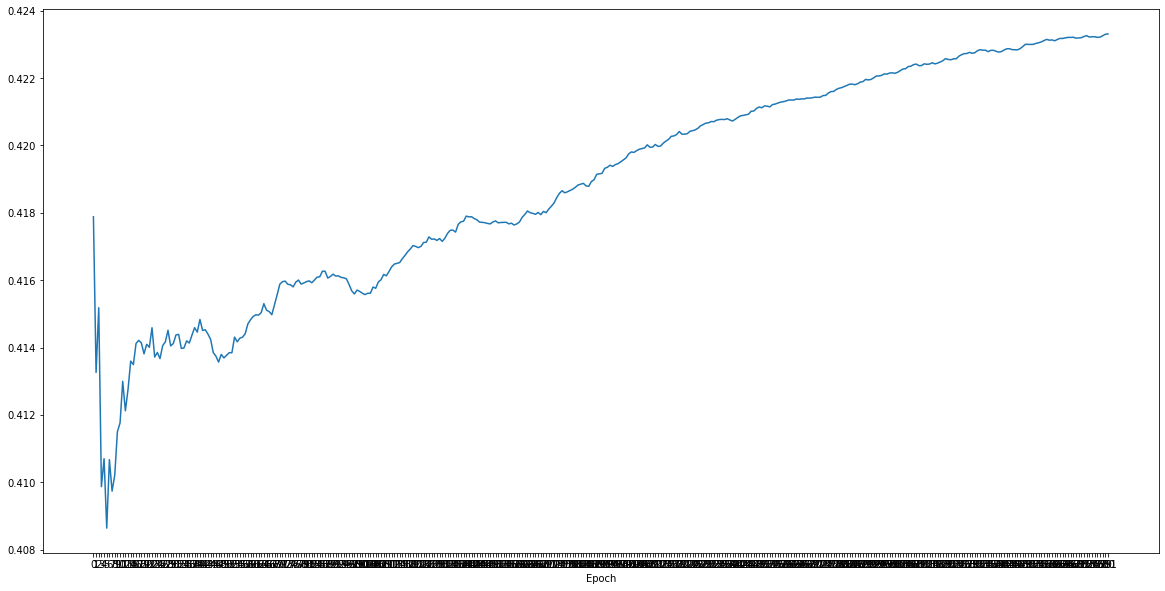

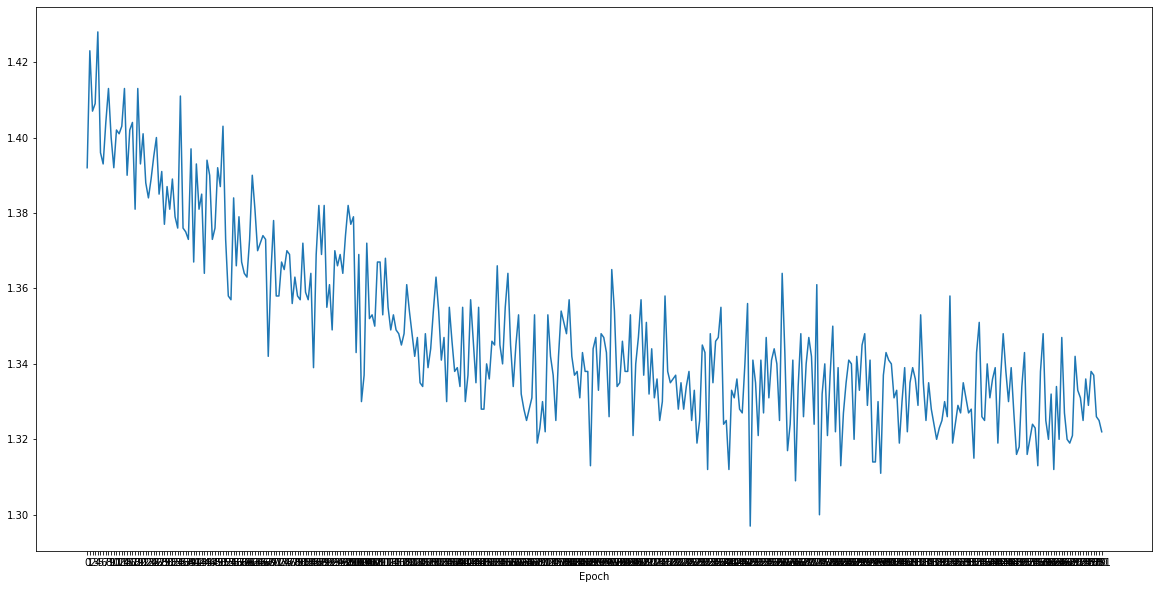

In [55]:
plot_train_info(train_correct_rate, "train correct rate")
plot_train_info(train_loss, "train loss")

### Test DPN

In [24]:
model_PATH = f"{gd_root}/models/{PATH_DPN}"
test_net = DPN92()
if device == 'cuda':
    test_net = torch.nn.DataParallel(test_net)
    cudnn.benchmark = True
test_net.load_state_dict(torch.load(model_PATH))

<All keys matched successfully>

In [ ]:
testing(test_net)

In [ ]:
test_for_each(test_net)

---
---
## Run the model in project test data 

### Load test data

In [44]:
project_testset = np.load(f"{gd_root}/data/test_data/y_test.npy").astype(np.uint8)
project_testset = np.moveaxis(project_testset, -1, 2)
project_testset = np.moveaxis(project_testset, 2, 1)
project_testset.shape
type(project_testset)

(12000, 3, 32, 32)

numpy.ndarray

### Convert to DataLoader ([Convertion Reference](https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader))

In [45]:
from torch.utils import data
tensor_testset = torch.Tensor(project_testset)
the_dataset = data.TensorDataset(tensor_testset)
project_test_loader = data.DataLoader(the_dataset, 
                                      batch_size=32,
                                      num_workers=8,
                                      pin_memory=True
                                     )
test_batch_len = len(project_test_loader)

### Run the test

In [46]:
predict_result = []

In [47]:
def run_project_test(net, model_path):
    net.load_state_dict(torch.load(model_path))
    
    test_pbar = progress_bar(test_batch_len)
    
    with torch.no_grad():
        for index, imgs in enumerate(project_test_loader):
            
            imgs = torch.stack([torch.Tensor(i) for i in imgs]).squeeze()
            
            if device == 'cuda':
                imgs.cuda()
                
            outputs = net(imgs)
            _, predicted = torch.max(outputs.data, 1)
            
            for p in predicted:
                predict_result.append(p)
            
            test_pbar.update(index)
      
    print(len(predict_result))

In [48]:
model_PATH = f"{gd_root}/models/{PATH_DPN}"
p_test_net = DPN92()
if device == 'cuda':
    p_test_net.to(device)
    p_test_net = torch.nn.DataParallel(p_test_net)
    cudnn.benchmark = True
run_project_test(p_test_net, model_PATH)

DPN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(96, 272, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 272, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(

Progress:  99% |####################### | Elapsed Time: 0:00:12 ETA:   0:00:00 

12000


In [49]:
len(predict_result)

12000

### Save to csv file

In [50]:
def save_to_csv(result: list):
    result_df = pd.DataFrame(
        list(predict_result),
        columns=["Category"]
    )
    result_df.index.name = "Index"
    # result_df
    result_df.to_csv(f"{gd_root}/predict_result.csv")

In [51]:
save_to_csv(predict_result)